In [82]:
import graphviz
import librosa
import librosa.display
import numpy as np
import pickle
import random
import glob
import re
import matplotlib.pyplot as plt


import tensorflow.keras
from tensorflow.python.keras import Sequential
from tensorflow.keras.optimizers import RMSprop, Adam, Adagrad
from tensorflow.keras.layers import Activation, Dense, Dropout, Flatten
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import LabelEncoder

%matplotlib inline

### TODO: Talk about why 3 second time slots
### TODO: Data augmentation?
### TODO: Batch sizes?
### TODO: Softmax at the end

# Citations: 

Reference 

> Keras Blog: https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html

> YerevaNN: https://yerevann.github.io/2016/06/26/combining-cnn-and-rnn-for-spoken-language-identification/
- 1x{500, 250, 100) GRU cells atop each input layer, fully connected at the end 
- Combine CNNs and RNNs 
- Do not perform subsampling 

> Audio Scene Classification with Deep Recurrent Neural Networks: https://arxiv.org/pdf/1703.04770
- Use Mel Frequency Cepstral Coefficients (MFCCs) as low-level feature vectors 

> Deep learning using EEG spectrograms for prognosis in idiopathic rapid eye movement behavior disorder (RBD): https://www.biorxiv.org/content/biorxiv/early/2018/01/17/240267.full.pdf
 - "Our design philosophy has been to enable the network to find local features
first and create larger views of data with some temporal (but not frequency)
shift invariance via max-pooling"
- 3 stacked RNN layers (LSTM, LSTM, GRU) with 32 hidden units with dropout
- USE AUC to measure classification performance

> Stanford cs229: http://cs229.stanford.edu/proj2016/report/IrvinChartockHollander-RecurrentNeuralNetworkswithAttentionforGenreClassification-report.pdf 
- Use MFCCs with LSTM, and LSTM with attention
- Multinomial logistic (softmax) regression
- Droput (possibly .2) for regularization after each LSTM 
- Categorical cross-entropy loss
- Implement gradient clipping

> GRU Cells on Music Modeling: https://arxiv.org/abs/1412.3555
- "A recurrent neural network (RNN) is an extension of a conventional feedforward neural network,
which is able to handle a variable-length sequence input. The RNN handles the variable-length
sequence by having a recurrent hidden state whose activation at each time is dependent on that of
the previous time."
- Gated units (GRU & LSTM) superior to traditional units within RNNs for this task

> Batch Normalization: https://arxiv.org/pdf/1502.03167.pdf
- Higher learning rates, less careful about initilization, acts as a regularizer and may eliminate need for using dropout 

In [2]:
# Load in datasets and combine into one
with open('../data/temp/dataset1.pkl', 'rb') as f:
    df1 = pickle.load(f)
    
with open('../data/temp/dataset2.pkl', 'rb') as f:
    df2 = pickle.load(f)

df = df1 + df2

In [70]:
frac = 0.80
split = int(np.floor(len(df) * frac))
random.shuffle(df)

train = df[:split]
test = df[split:]

_, X_train, y_train = zip(*train)
_, X_test, y_test = zip(*test)

# Still use 128x128 spectrograms for the RNN 

# Reshape for CNN input
X_train = np.array([x.reshape( (128, 128) ) for x in X_train])
X_test = np.array([x.reshape( (128, 128) ) for x in X_test])

# One-Hot encoding for classes
y_train = np.array(tensorflow.keras.utils.to_categorical(y_train, 4))
y_test = np.array(tensorflow.keras.utils.to_categorical(y_test, 4))

In [71]:
# librosa.display.specshow(X_train[8])

Specity, compile, and evaluate model

Improvements:

*   Modify model architecture, loss, and optimizer to improve model
*   Assess model performance on a variety of measure appropriate for multinomial classification problem
*   Compare model performance with different inputs: percussive only, harmonics only, both (current)

model = Sequential()
input_shape=(128, 128, 1)

model.add(Conv2D(24, (5, 5), strides=(1, 1), input_shape=input_shape))
model.add(MaxPooling2D((4, 2), strides=(4, 2)))
model.add(Activation('sigmoid'))

model.add(Conv2D(48, (5, 5), padding="valid"))
model.add(MaxPooling2D((4, 2), strides=(4, 2)))
model.add(Activation('sigmoid'))

model.add(Conv2D(48, (5, 5), padding="valid"))
model.add(Activation('sigmoid'))

model.add(Flatten())
model.add(Dropout(rate=0.5))

model.add(Dense(64))
model.add(Activation('sigmoid'))
model.add(Dropout(rate=0.5))

model.add(Dense(4))
model.add(Activation('softmax'))

In [72]:
input_shape = (128,128)
num_classes = 4

model = Sequential()
model.add(LSTM(64,
               input_shape = input_shape,
               return_sequences=True, 
               dropout=0.1, recurrent_dropout=0.1))
# Dropout after each LSTM layer, as proposed 
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Activation('relu'))
model.add(Dropout(rate=0.5))

# Output 
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))

model.compile(
	optimizer="Adam",
	loss="categorical_crossentropy",
	metrics=['accuracy'])

In [73]:
history = model.fit(X_train,
          y_train,
          epochs=5,
          validation_split=0.10,
          verbose=1.0)

Train on 849 samples, validate on 95 samples
Epoch 1/5
849/849 [==============================] - 11s 13ms/step - loss: 1.4334 - acc: 0.2638 - val_loss: 1.3410 - val_acc: 0.3053
Epoch 2/5
849/849 [==============================] - 7s 8ms/step - loss: 1.2611 - acc: 0.4264 - val_loss: 1.3120 - val_acc: 0.4000
Epoch 3/5
849/849 [==============================] - 7s 8ms/step - loss: 1.1671 - acc: 0.5112 - val_loss: 1.2765 - val_acc: 0.4000
Epoch 4/5
849/849 [==============================] - 7s 8ms/step - loss: 1.1047 - acc: 0.5371 - val_loss: 1.2636 - val_acc: 0.3684
Epoch 5/5
849/849 [==============================] - 7s 8ms/step - loss: 1.0127 - acc: 0.5771 - val_loss: 1.2671 - val_acc: 0.4211


In [76]:
score = model.evaluate(
	x=X_test,
	y=y_test)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

236/236 [==============================] - 1s 2ms/step
Test loss: 1.2765682673050185
Test accuracy: 0.3983050852508868


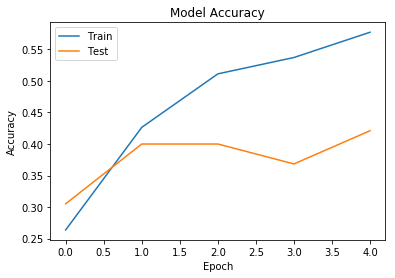

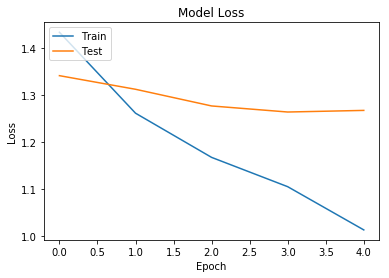

In [85]:
plot_model(model, to_file='../figures/rnn1.png', show_shapes=True)

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()